# Dark Matter Spectra Reweighted from CRPropa

In [1]:
from __future__ import print_function

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load HDMSpectra
from HDMSpectra import HDMSpectra

import numpy as np
#import scipy as sp
#import scipy.interpolate as interpolate
#import scipy.integrate as integrate
#import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.integrate as integrate
from scipy.integrate import quad
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif' 
mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['ytick.labelsize'] = 26
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['legend.fontsize'] = 26
mpl.rcParams['legend.frameon'] = False
import seaborn as sns
plt.style.use('/Users/barbaraskrzypek/Documents/IceCube/LVNeutrinos/LV/paper.mplstyle')

## Dark Matter Spectra 

In [2]:
data = '/Users/barbaraskrzypek/Documents/IceCube/EBL/HDMSpectra/data/HDMSpectra.hdf5' # location of hdf5 file

## CRPropa Spectra 

In [292]:
file_galactic_cmb = np.genfromtxt("PhotonSpectra/crpropa_photon_output_PowerLawCosmologicalEvolution_10_0.1_False.txt")
file_galactic_ebl = np.genfromtxt("PhotonSpectra/crpropa_photon_output_PowerLawCosmologicalEvolution_10_0.1_True.txt")

file_extragalactic_cmb = np.genfromtxt("PhotonSpectra/crpropa_photon_output_PowerLawCosmologicalEvolution_10_10.0_False.txt")
file_extragalactic_ebl = np.genfromtxt("PhotonSpectra/crpropa_photon_output_PowerLawCosmologicalEvolution_10_10.0_True.txt")


## Weights 

### Galactic Weights

To get the galactic spectrum weights, we sum over initial photon positions multiplied by the Navarro-Frenk-White DM density profile in the following way: 

$$\frac{d\phi}{dEd\Omega} = \frac{1}{4\pi m_{DM} \tau_{DM}}\frac{dN}{dE_{\gamma}}\sum \Delta r \times \rho^{\text{NFW}}(r),$$

where the NFW profile is defined as 

$$\rho^{\text{NFW}}(r) = \frac{\rho_s}{r/r_s\big(1+r/r_s\big)^2},$$

with $r_s = 24$ kpc and $\rho_s = 0.18$ GeV/cm$^3$. We propagate galactic photons from 0 to 100 kpc with a cosmological redshift evolution and an initial power law spectrum following 

$$ \phi \propto \Big(\frac{E}{E_c}\Big)^{-1}$$

with $E_c = 10^7$ GeV and $E_{\text{min}} = 100$ GeV. In the function below, we then factorize the weights into two componts:

$$\text{weights} = \text{weights_position}\times \text{weights_energy}$$

where weights_position is the sum over the initial photon distances and weights_energy is the contribution from the dark matter number density, depending on energy, along with the factor of one over the initial photon spectrum and the final energy squared:

$$\text{weights_position} =  \frac{1}{4\pi m_{DM} \tau_{DM}} \sum \Delta r \times \rho(r),$$

$$\text{weights_energy} = \frac{dN_{DM}}{dE_{\gamma}}\Big(\frac{E_i}{E_c}\Big)E_f^2$$

The product of these weights is then applied to the final spectrum from CRPropa:

$$ \text{reweighted spectrum} = \text{weights_position}\times\text{weights_energy}\times \Big(\frac{dN_f}{dE_{\gamma}}\Big)_{\text{CRPropa}}$$

In [165]:
kpcTocm = 3.086*10**21
rs = 24 #in kpc 
def weights_galactic(r,mDM,tauDM):
    c = (1/(4*(np.pi)*mDM*tauDM))
    f = 0.18/((r/rs)*(1+r/rs)**2)
    rho = c*f
    return rho

In [168]:
weights_galactic(0.01,10**6,10**28)

3.4348837713081945e-33

### Extragalactic weights

To obtain the extragalactic weights, we similarly sum over initial photon positions starting from 100 kpc. The spectra are calculated in the following way: 

$$ \frac{d\phi}{dE d\Omega} = \frac{\Omega_{DM}\rho_c}{4\pi m_{DM}\tau_{DM}}\sum \Delta z \frac{1}{H(z)}\frac{dN}{dE^{\prime}}$$

where the critical energy density $\rho_c = 5.5\times 10^{-6}$ GeV/cm$^3$ and $E^{\prime} = E(1+z).$ We start with the same power-law spectrum shown above, with the exception that we propagate over distances of 100 kpc to 10 Mpc. We then facrorize the weights in a similar way to the galactic case: 

$$\text{weights} = \text{weights_position}\times \text{weights_energy}$$

where weights_position is the sum over the initial photon redshifts and weights_energy is the contribution from the dark matter number density, depending on energy, along with the factor of one over the initial photon spectrum and the final energy squared:

$$ \text{weights_position} =  \frac{\Omega_{DM}\rho_c}{4\pi m_{DM}\tau_{DM}}\sum \Delta z \frac{1}{H(z)(1+z)}$$

$$ \text{weights_energy} = \frac{dN_{DM}}{dE_{\gamma}}\Big(\frac{E_i}{E_c}\Big)E_f^2$$

The product of these weights is then applied to the final spectrum from CRPropa:

$$ \text{reweighted spectrum} = \text{weights_position}\times\text{weights_energy}\times \Big(\frac{dN_f}{dE_{\gamma}}\Big)_{\text{CRPropa}}$$

In [225]:
rho_c = 5.5*10**(-6) #in units GeV/cm^3
omega_DM = 0.23
omega_m = 0.27
c = 3*10**5 #in km/s
H0 = 67.7 #in (km/s)/(Mpc)
def H(z):
    h = np.sqrt(omega_m*(1+z)**3+(1-omega_m))
    return h
def weights_extragalactic(r,mDM,tauDM): 
    c = (1/(4*(np.pi)*mDM*tauDM)) 
    z = (H0*r/c)*10**(-3) #converts distance in kpc to redshift 
    f = 1/(H0*H(z)*(1+z)) 
    return c*f

In [226]:
weights_extragalactic(1000,10**6,10**28)

1.0715766791705258e-129

## Plots 

### Initial & Attenuated Spectra from CRPropa

In [311]:
#makes a plot showing the initial and attenuated spectra from CRPropa

def MakeInjPlot(file,gamma,irb = True): 
    
    if irb == True: 
        string = "CMB and IRB"
    else: string = "CMB Only"
    
    #energies
    
    photo_energies_initial = np.array([xx[5] for xx in file if xx[2] == 22])
    photo_energies_final = np.array([xx[3] for xx in file if xx[2] == 22])
    
    #energy binning: 
    
    lEbins = np.logspace(2,6,40) #logarithmic bins 
    lEcens = (lEbins[1:] + lEbins[:-1]) / 2 #logarithmic bin centers
    dE = lEbins[1:] - lEbins[:-1] #bin widths 
    
    # make the figure 
    
    fig = plt.figure(figsize=(7,6))
    cm = mpl.pyplot.get_cmap('RdPu')
    color_min = 0.1
    color_max = 0.9
    color_range = color_max-color_min
    colors = [cm(color_range*i/(8-1)+color_min) for i in range(8)]
    
    plt.hist(photo_energies_initial*10**(9), bins = np.logspace(2,6,40),
             histtype="step", lw = 2, density = True, color = colors[3],label = r"$\gamma =$ {gamma} initial".format(gamma = gamma),weights = photo_energies_initial**2)
    #y = np.histogram(photo_energies_original*10**(9), bins = np.logspace(2,6,36), density = False, weights = photo_energies_original*10**9**2)
    plt.hist(photo_energies_final*10**9, bins = np.logspace(2,6,40),
             histtype="step", lw = 2, density = True, color = colors[5],label = r"$\gamma =$ {gamma} (final)".format(gamma = gamma),weights = (photo_energies_final*10**9)**2)

    plt.legend(bbox_to_anchor=(.90, .95), loc='upper left', borderaxespad=0.,frameon = True,shadow = True)
    #plt.ylim(10**21,10**26)
    plt.semilogy()
    plt.semilogx()
    plt.xlim(1e2,1e7)
    #plt.ylim(1e2,1e6)
    plt.xlabel(r"$E_\gamma$/GeV",fontsize = 16)
    plt.ylabel(r"$E^2 dN/dE$",fontsize = 16)
    plt.title(string,fontsize = 20)
    plt.savefig("/Users/barbaraskrzypek/Documents/PowerLawSpectraInj_{gamma1}.pdf".format(gamma1=int(gamma*10)),dpi = 400,bbox_inches = "tight")
    
    #return rw

### Fermi-LAT and IceCube data 

In [120]:
# FERMI PART
fermi = np.genfromtxt("./modelA_integrated_fluxes.txt")
e_fermi_GeV = (fermi[:,0] + fermi[:,1])*1.0e-3/2.
upper_limits = [False]*len(e_fermi_GeV)

In [121]:
bins = np.logspace(np.log10(19952.6), np.log10(3.16228e8), 14) 
bins = bins[1:9]
enu = np.logspace(np.log10(bins[0]), 8, 500)
# Plot the segmented powerlaw flux
def flux(energy, norm, index=2.):
    energyIn100TeV = energy/1e5
    return norm*1e-18*(energyIn100TeV)**(-index)
xmin = bins[0]
xmax = bins[-1]
energy_centers = np.power(10, (lambda x: (x[:-1]+x[1:])/2.)(np.log10(bins)))
intervals = np.array([(0.0, 143.54622664666903, 500.0), (0.0, 2.123691768833845, 5.635437314697244), (4.948055179047638, 6.382657005897758, 8.002066239102458), (0.0, 0.5177890921151547, 1.553873383727041), (0.0, 0.2634178446276476, 1.1728578975033623), (0.9183994046204971, 1.8237591302698424, 3.046362634593988), (0.0, 0.486221306109142, 1.570990230774263), (0.0, 0.0, 0.1869868977346414), (0.0, 0.0, 1.6417124479048653), (0.0, 122.96672124580368, 500.0), (0.0, 80.46916717685278, 500.0), (0.0, 224.50607289774382, 500.0), (0.0, 126.68963542182684, 500.0)])[1:8]
intervals = flux(energy_centers[:,None], intervals, 2.)*((energy_centers**2.0)[:,None])
y = np.array([x[1] for x in intervals])
q_low = np.array([q_low for q_low, _, _ in intervals])
q_high = np.array([q_high for _, _, q_high in intervals])
q_max= np.array([q_max for _, q_max, _ in intervals])
y_low = q_max-q_low
y_high = q_high-q_max
yerr = np.array([y_low, y_high])
xerr = np.array([energy_centers-bins[:-1], bins[1:]-energy_centers])

### DM Reweighting Plots  

In [333]:
#makes a plot showing the galactic, extragalactic, and combined reweighted DM spectra 

def MakeGammaDMAttPlot(file_galactic,file_extragalactic,mDM,initial_state,irb = True):
    
    kpcTocm = 3.086*10**21
    
    if irb == True:
        string = "CMB and EBL"
    else: string = "CMB Only"
    
    #particle ID:
    if initial_state == 5:
        state = r"$b\bar{b}$"
    if initial_state == 15:
        state = r"$\tau^{+}\tau^{-}$"
    if initial_state == 24:
        state = r"$W^{+}W^{-}$"
    if initial_state == 13:
        state = r"$\mu^{+}\mu^{-}$"
        
    #Photon Energies
    
    photo_energies_initial = np.array([xx[5] for xx in file_galactic if xx[2] == 22])
    photo_energies_final = np.array([xx[3] for xx in file_galactic if xx[2] == 22])
    photo_positions_initial = np.array([xx[6] for xx in file_galactic if xx[2] == 22])
    
    photoEG_energies_initial = np.array([xx[5] for xx in file_extragalactic if xx[2] == 22])
    photoEG_energies_final = np.array([xx[3] for xx in file_extragalactic if xx[2] == 22])
    photoEG_positions_initial = np.array([xx[6] for xx in file_extragalactic if xx[2] == 22])
    
    #DM Spectrum:
    
    # Specify the particles & parameters 
    finalstate = 22 # pdg id of the photon
    initialstate = initial_state # pdg id of the b-quark
    x = np.logspace(1,6,50) # Energy values
    R_galactic = np.linspace(0.001,0.1,100) #initial galactic positions in Mpc
    R_extragalactic = np.linspace(0.1,10,100) #initial extragalactic positions in Mpc
    dR_galactic = (0.1-0.001)/100
    dR_extragalactic = (10-0.1)/100
    
    #energy binning 
    
    lEbins = np.logspace(1,6,50) #logarithmic bins 
    lEcens = (lEbins[1:] + lEbins[:-1]) / 2 #logarithmic bin centers
    dE = lEbins[1:] - lEbins[:-1] #bin widths 
    
    # Extract & reweight the spectrum using HDMSpectra.spec
    dNdx = HDMSpectra.spec(finalstate, initialstate, x*2/mDM, mDM, data)
    spectrum = dNdx*(2/mDM)
    galactic_sum = 0 
    for i in range(len(R_galactic)-1):
        r = R_galactic[i]*10**(3) #convert Mpc to kpc
        galactic_sum += weights_galactic(r,mDM,10**28)*dR_galactic*10**(3)*kpcTocm
    print(galactic_sum)
    extragalactic_sum = 0
    for i in range(len(R_extragalactic)-1):
        r = R_extragalactic[i]*10**(3) #convert Mpc to kpc
        dR = dR_galactic*H0/c #converts Mpc to redshift 
        extragalactic_sum += weights_extragalactic(r,mDM,10**28)*dR
    print(extragalactic_sum)
    spectrum_weighted = spectrum*(galactic_sum+extragalactic_sum)
    
    #weights
    photo_energies_initial *= 10**9
    photo_energies_final *= 10**9
    weights_r = np.zeros_like(photo_energies_final)
    for i in range(len(R_galactic) - 1):
        r = (R_galactic[i]+R_galactic[i+1])/2 #takes the midpoint of each bin
        r *= 10e3
        delta_r = R_galactic[i+1]-R_galactic[i]
        delta_r *= 10e3 #convert Mpc to kpc
        #boolean array that selects the events in a given bin
        bin_bool = (photo_positions_initial >= R_galactic[i]) & (photo_positions_initial < R_galactic[i+1])
        #
        photo_positions_initial_bin = photo_positions_initial[bin_bool]
        photo_energies_final_bin = photo_energies_final[bin_bool]
        weights_final_bin = np.ones_like(photo_energies_final_bin)*weights_galactic(r,mDM,10**28)*delta_r*kpcTocm
        weights_r[bin_bool] = weights_final_bin
    
    weightsEG_r = np.zeros_like(photoEG_energies_final)
    photoEG_energies_initial *= 10**9
    photoEG_energies_final *= 10**9
    for i in range(len(R_extragalactic) - 1):
        r = (R_extragalactic[i]+R_extragalactic[i+1])/2
        r *= 10e3 #converts Mpc to kpc
        delta_r = R_extragalactic[i+1]-R_extragalactic[i]
        delta_r *= H0/c #converts Mpc to redshift 
        #boolean array that selects the events in a given bin
        bin_bool = (photoEG_positions_initial >= R_extragalactic[i]) & (photoEG_positions_initial < R_extragalactic[i+1])
        #
        photo_positions_initial_bin = photoEG_positions_initial[bin_bool]
        photo_energies_final_bin = photoEG_energies_final[bin_bool]
        weights_final_bin = np.ones_like(photo_energies_final_bin)*weights_extragalactic(r,mDM,10**28)*delta_r
        weightsEG_r[bin_bool] = weights_final_bin
        
    weights_energies = np.zeros_like(photo_energies_final)
    for i in range(len(lEcens) - 1):
        #boolean array that selects the events in a given bin
        bin_bool = (photo_energies_final >= lEcens[i]) & (photo_energies_final < lEcens[i+1])
        #
        photo_energies_final_bin = photo_energies_final[bin_bool]
        photo_energies_initial_bin = photo_energies_initial[bin_bool]
        weights_final_bin = np.ones_like(photo_energies_final_bin)*(spectrum[i])*((photo_energies_initial_bin/(10**7))**(1))*(photo_energies_final_bin)**2
        weights_energies[bin_bool] = weights_final_bin
        
    weightsEG_energies = np.zeros_like(photoEG_energies_final)
    for i in range(len(lEcens) - 1):
        #boolean array that selects the events in a given bin
        bin_bool = (photoEG_energies_final >= lEcens[i]) & (photoEG_energies_final < lEcens[i+1])
        #
        photo_energies_final_bin = photoEG_energies_final[bin_bool]
        photo_energies_initial_bin = photoEG_energies_initial[bin_bool]
        weightsEG_final_bin = np.ones_like(photo_energies_final_bin)*(spectrum[i])*((photo_energies_initial_bin/(10**7))**(1))*(photo_energies_final_bin)**2
    
    weights_final_galactic = weights_r*weights_energies
    weights_final_extragalactic = weightsEG_r*weightsEG_energies
    print(weights_final_galactic)
    print(weights_final_extragalactic)
    print(spectrum_weighted)
    
    # make the figure 
    
    fig = plt.figure(figsize=(7,6))
    cm = mpl.pyplot.get_cmap('RdPu')
    color_min = 0.1
    color_max = 0.9
    color_range = color_max-color_min
    colors = [cm(color_range*i/(8-1)+color_min) for i in range(8)]
    
    h1 = np.histogram(photo_energies_final, bins = np.logspace(1,6,51),weights = weights_final_galactic)
    h2 = np.histogram(photoEG_energies_final, bins = np.logspace(1,6,51),weights = weights_final_extragalactic)
    
    #plt.hist(x,bins = np.logspace(2,6,300),histtype = "step",lw = 2, density = False, color = colors[3],label = r"Initial Spectrum for $\gamma =$ {gamma}".format(gamma = gamma),weights = file_injected)
    #plt.hist(x,bins = np.logspace(2,6,300),histtype = "step",lw = 2, density = True, color = colors[5],label = r"Attenuated Spectrum for $\gamma =$ {gamma}".format(gamma = gamma),weights = file_attenuated)
    plt.hist(photo_energies_final, bins = np.logspace(1,6,50),
             histtype="step", lw = 2, density = False, color = colors[2],label = r"Reweighted DM Spectrum (Galactic)",weights = weights_final_galactic)
    plt.hist(photoEG_energies_final, bins = np.logspace(1,6,50),
             histtype="step", lw = 2, density = False, color = colors[4],label = r"Reweighted DM Spectrum (Extragalactic)",weights = weights_final_extragalactic)
    plt.hist(x, bins = np.logspace(1,6,50),
             histtype="step", lw = 2, density = False, color = colors[6],label = r"Reweighted DM Spectrum (Both)",weights = h1[0]+h2[0])
    #plt.hist(x,bins = np.logspace(1,6,300),histtype = "step",lw = 2,density = False,color = colors[7],label = r"Reweighted DM Spectrum",weights = (spectrum/(x**(gamma)*np.exp((-x/(10**8)))))*file_attenuated)
    #plt.hist(x,bins = np.logspace(1,6,300),histtype = "step",lw = 2,density = False,color = colors[7],label = r"Reweighted DM Spectrum",weights = (spectrum*x**2/(file_injected))*file_attenuated)
    #plt.hist(x, bins = np.logspace(1,6,50),histtype="step", lw = 2, density = False,color ='orange',label = r"Initial DM Spectrum \par from HDMSpectra \par (Galactic Component Only)",weights = spectrum_weighted)
    
    #plt.errorbar(lEcens,yhist[0],yerr = dy,fmt = 'o',color = 'blue',alpha = 0.4)
    plt.errorbar(energy_centers, np.array(y), xerr=np.array(xerr), yerr=np.array([y_low, y_high]),
             color='black', marker='o',
             markerfacecolor=colors[6],
             linestyle='None', capsize=3,
             markersize = 6,
             elinewidth=1., label = "Neutrinos (HESE 7.5yr, this work)", zorder = 3) 
    plt.errorbar(e_fermi_GeV, fermi[:,2]*e_fermi_GeV,
             xerr=np.array([np.abs(fermi[:,0]*1.0e-3-e_fermi_GeV),
                            np.abs(fermi[:,1]*1.0e-3-e_fermi_GeV)]),
             yerr=np.array([np.abs(fermi[:,3]*e_fermi_GeV),
                            np.abs(fermi[:,4]*e_fermi_GeV)]),
             uplims = upper_limits,
             color='black',
             markerfacecolor=colors[4], marker='^',
             linestyle='None', capsize=2,
             markersize = 8,
             elinewidth=1., label = "Gamma rays (Fermi 2017)", zorder = 3)
    plt.legend(bbox_to_anchor=(.90, .95), loc='upper left', borderaxespad=0.,frameon = True,shadow = True)
    #plt.ylim(10**21,10**26)
    plt.semilogy()
    plt.semilogx()
    plt.xlim(1e2,1e7)
    #plt.ylim(1e-15,1e-6)
    #plt.ylim(1e2,1e6)
    plt.xlabel(r"$E_\gamma$/GeV",fontsize = 16)
    plt.ylabel(r"$E^2 d\phi/dE$",fontsize = 16)
    plt.title(string+r", DM Spectrum for $\chi \rightarrow$"+state,fontsize = 20)
    plt.savefig("/Users/barbaraskrzypek/Documents/DMSpectraAtt_{particle}.pdf".format(particle = initial_state),dpi = 400,bbox_inches = "tight")
    
    #return rw

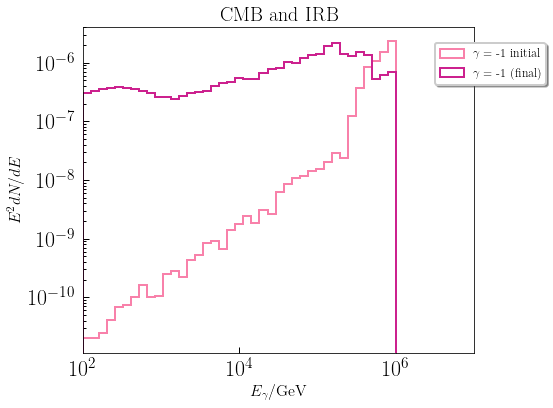

In [313]:
MakeInjPlot(file_galactic_ebl,-1,True)

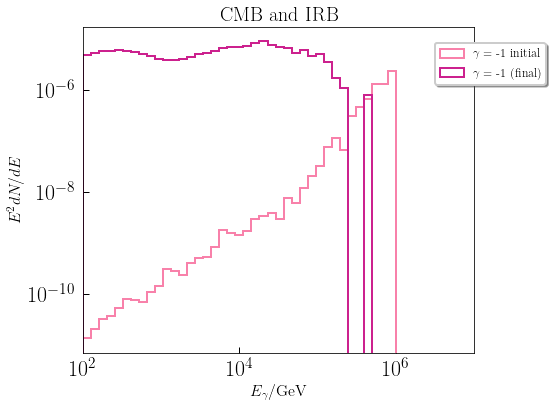

In [315]:
MakeInjPlot(file_extragalactic_ebl,-1,True)

In [318]:
print(np.array([xx[6] for xx in file_extragalactic_ebl if xx[2] == 22]))

[1.79747 1.79747 1.79747 ... 6.56877 6.56877 6.56877]


In [270]:
np.linspace(0.001,0.1,100)

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  ])

1.4571324937206972e-13
8.972013566257001e-135
[1.23670089e-14 2.41384697e-14 1.87378442e-14 ... 2.73715456e-14
 5.38136132e-14 7.37952336e-14]
[0. 0. 0. ... 0. 0. 0.]
[5.03927904e-13 4.14869733e-13 3.44525760e-13 2.83702130e-13
 2.29911797e-13 1.85587151e-13 1.48649057e-13 1.18253261e-13
 9.35029163e-14 7.34583072e-14 5.73608093e-14 4.45548537e-14
 3.44237584e-14 2.64586976e-14 2.02393396e-14 1.54086851e-14
 1.16745242e-14 8.81265795e-15 6.62051329e-15 4.95067233e-15
 3.68549032e-15 2.72754166e-15 2.00766497e-15 1.46903041e-15
 1.06743065e-15 7.69725193e-16 5.50596617e-16 3.90168242e-16
 2.73410694e-16 1.88902069e-16 1.27887185e-16 8.47887206e-17
 5.56099659e-17 3.58903155e-17 2.25838284e-17 1.37880322e-17
 8.14570383e-18 4.62618242e-18 2.50500152e-18 1.28652681e-18
 6.22245563e-19 2.81314412e-19 1.18728059e-19 4.69659292e-20
 1.74854843e-20 6.45514790e-21 2.64432148e-21 1.32832056e-21
 7.42395724e-22 0.00000000e+00]
(50,)


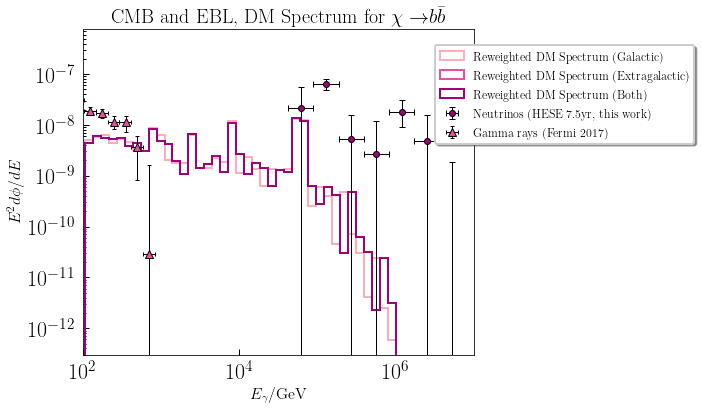

In [335]:
MakeGammaDMAttPlot(file_galactic_ebl,file_extragalactic_ebl,2*10**6,5)

1.4571324937206972e-13
8.972013566257001e-135
[1.45339414e-16 9.47596079e-15 0.00000000e+00 ... 1.23645681e-15
 1.66776129e-15 2.96889812e-15]
[0. 0. 0. ... 0. 0. 0.]
[5.03927904e-13 4.14869733e-13 3.44525760e-13 2.83702130e-13
 2.29911797e-13 1.85587151e-13 1.48649057e-13 1.18253261e-13
 9.35029163e-14 7.34583072e-14 5.73608093e-14 4.45548537e-14
 3.44237584e-14 2.64586976e-14 2.02393396e-14 1.54086851e-14
 1.16745242e-14 8.81265795e-15 6.62051329e-15 4.95067233e-15
 3.68549032e-15 2.72754166e-15 2.00766497e-15 1.46903041e-15
 1.06743065e-15 7.69725193e-16 5.50596617e-16 3.90168242e-16
 2.73410694e-16 1.88902069e-16 1.27887185e-16 8.47887206e-17
 5.56099659e-17 3.58903155e-17 2.25838284e-17 1.37880322e-17
 8.14570383e-18 4.62618242e-18 2.50500152e-18 1.28652681e-18
 6.22245563e-19 2.81314412e-19 1.18728059e-19 4.69659292e-20
 1.74854843e-20 6.45514790e-21 2.64432148e-21 1.32832056e-21
 7.42395724e-22 0.00000000e+00]
(50,)


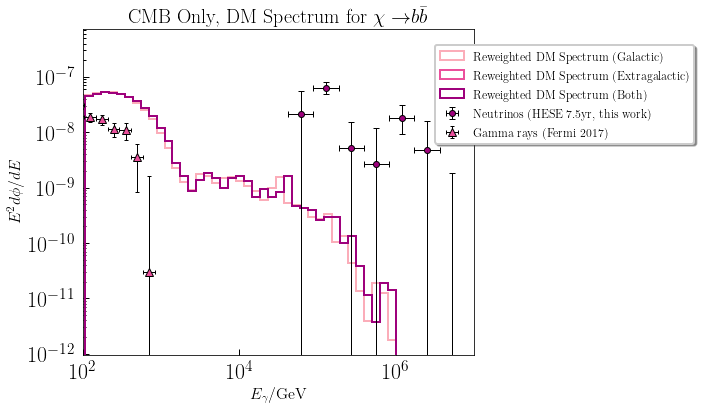

In [336]:
MakeGammaDMAttPlot(file_galactic_cmb,file_extragalactic_cmb,2*10**6,5,False)

### CRPropa Histograms

In [260]:
def MakePositionPlot(file,irb = True):


    if irb == True:
        string = "CMB and IRB"
    else: string = "CMB Only"
        
    photo_positions_initial = np.array([xx[6] for xx in file if xx[2] == 22])
    
    
    # make the figure 
    
    fig = plt.figure(figsize=(7,6))
    cm = mpl.pyplot.get_cmap('RdPu')
    color_min = 0.1
    color_max = 0.9
    color_range = color_max-color_min
    colors = [cm(color_range*i/(8-1)+color_min) for i in range(8)]
    
    #plt.hist(x,bins = np.logspace(2,6,300),histtype = "step",lw = 2, density = False, color = colors[3],label = r"Initial Spectrum for $\gamma =$ {gamma}".format(gamma = gamma),weights = file_injected)
    #plt.hist(x,bins = np.logspace(2,6,300),histtype = "step",lw = 2, density = True, color = colors[5],label = r"Attenuated Spectrum for $\gamma =$ {gamma}".format(gamma = gamma),weights = file_attenuated)
    #plt.hist(x,bins = np.logspace(1,6,300),histtype = "step",lw = 2,density = False,color = colors[7],label = r"Reweighted DM Spectrum",weights = (spectrum/(x**(gamma)*np.exp((-x/(10**8)))))*file_attenuated)
    plt.hist(photo_positions_initial,
             histtype="step", lw = 2, density = False, color = colors[3],label = r"Positions at source")
    #plt.hist(photo_energies_trajectories, bins = np.logspace(1,3,10),
    #         histtype="step", lw = 2, density = True, color = colors[6],label = r"Original Distribution")
    #plt.hist(x,bins = np.logspace(1,6,300),histtype = "step",lw = 2,density = False,color = colors[7],label = r"Reweighted DM Spectrum",weights = (spectrum/(x**(gamma)*np.exp((-x/(10**8)))))*file_attenuated)
    #plt.hist(x,bins = np.logspace(1,6,300),histtype = "step",lw = 2,density = False,color = colors[7],label = r"Reweighted DM Spectrum",weights = (spectrum*x**2/(file_injected))*file_attenuated)
    #plt.hist(x, bins = np.logspace(1,6,300),histtype="step", lw = 2, density = False,color ='orange',label = r"Initial DM Spectrum \par from HDMSpectra",weights = spectrum)
    
    plt.legend(bbox_to_anchor=(.90, .95), loc='upper left', borderaxespad=0.,frameon = True,shadow = True)
    #plt.ylim(10**21,10**26)
    #plt.semilogy()
    #plt.semilogx()
    #plt.xlim(1e1,1e3)
    #plt.ylim(1e-15,1e-6)
    #plt.ylim(1e2,1e6)
    plt.title(string+r",Positions at Source (Mpc)",fontsize = 16)
    plt.ylabel(r"Number of Events",fontsize = 16)
    #plt.title(r"CMB and IRB, DM Spectrum for $\chi \rightarrow$"+state,fontsize = 20)
    plt.savefig("/Users/barbaraskrzypek/Documents/DMPositions){irb}.pdf".format(irb = irb),dpi = 400,bbox_inches = "tight")
    
    #return rw

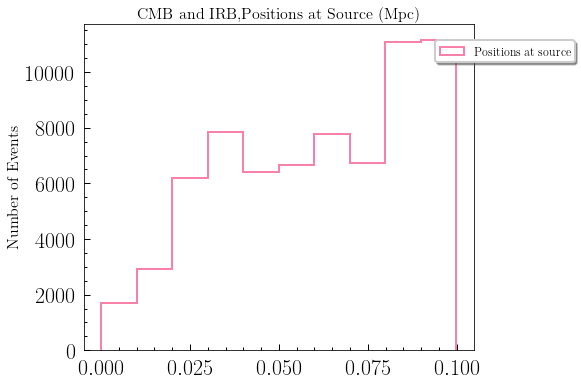

In [289]:
MakePositionPlot(file_galactic_ebl,True)

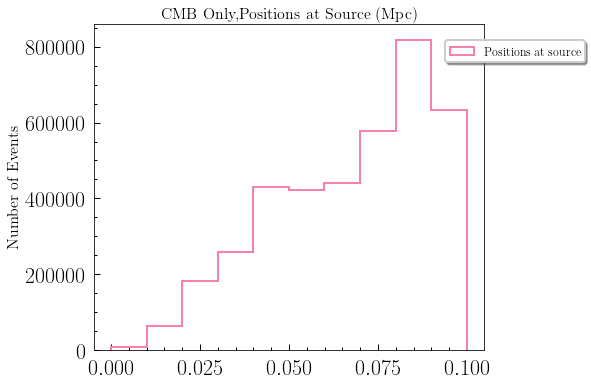

In [262]:
MakePositionPlot(file_galactic_cmb,False)

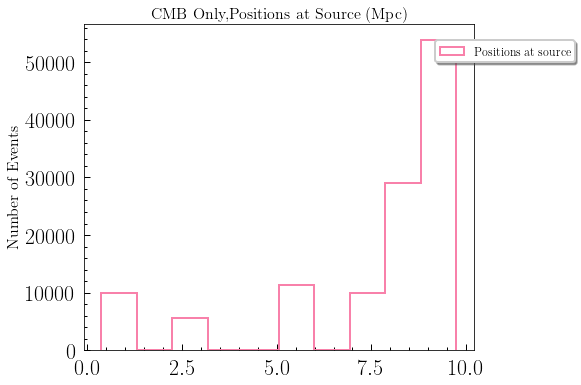

In [316]:
MakePositionPlot(file_extragalactic_cmb,False)

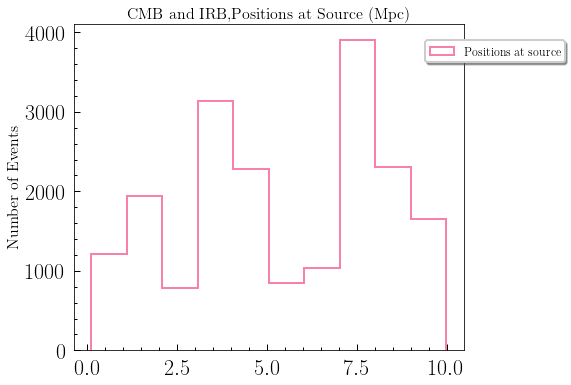

In [291]:
MakePositionPlot(file_extragalactic_ebl,True)